In [17]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from numba import prange

In [ ]:
@jit(nopython=True, cache=True)  # Entferne parallel=True
def initialize_lattice(N, m0):
    num_up = int((1 + m0) / 2 * N * N)
    lattice = np.array([-1] * (N * N - num_up) + [1] * num_up)
    np.random.shuffle(lattice)
    return lattice.reshape((N, N))

@jit(nopython=True, cache=True)  # Entferne parallel=True
def compute_energy(lattice):
    energy = 0
    N = lattice.shape[0]
    for i in range(N):  # Entferne prange
        for j in range(N):
            S = lattice[i, j]
            neighbors = (lattice[(i + 1) % N, j] + lattice[i, (j + 1) % N] +
                         lattice[i - 1, j] + lattice[i, j - 1])
            energy += -S * neighbors
    return energy / 2

@jit(nopython=True, cache=True)  # Entferne parallel=True
def compute_magnetization(lattice):
    return np.sum(lattice)

@jit(nopython=True, cache=True)  # Entferne parallel=True
def metropolis_step(lattice, T):
    N = lattice.shape[0]
    random_indices = np.random.randint(0, N, size=(N * N, 2))
    random_probs = np.random.rand(N * N)
    for idx in range(N * N):
        i, j = random_indices[idx]
        S = lattice[i, j]
        neighbors = (lattice[(i + 1) % N, j] + lattice[i, (j + 1) % N] +
                     lattice[i - 1, j] + lattice[i, j - 1])
        dE = 2 * S * neighbors
        if dE < 0 or random_probs[idx] < np.exp(-dE / T):
            lattice[i, j] *= -1
    return lattice



@jit(nopython=True, cache=True)  # Entferne parallel=True
def compute_averages(N, m0, Ts, N_steps):
    E_av = np.zeros(len(Ts))
    M_av = np.zeros(len(Ts))
    E2_av = np.zeros(len(Ts))
    M2_av = np.zeros(len(Ts))
    C_v = np.zeros(len(Ts))  # Specific heat
    Chi = np.zeros(len(Ts))  # Susceptibility
    total_spins = N * N  # Total number of spins in the lattice

    for idx in range(len(Ts)):  # Loop over temperatures
        T = Ts[idx]
        lattice = initialize_lattice(N, m0)
        energies = np.zeros(N_steps)
        magnetizations = np.zeros(N_steps)

        for step in range(N_steps):  # Loop over Monte Carlo steps
            lattice = metropolis_step(lattice, T)
            energies[step] = compute_energy(lattice)
            magnetizations[step] = compute_magnetization(lattice)

        # Compute averages and normalize by the total number of spins
        E_av[idx] = np.sum(energies) / (N_steps * total_spins)
        M_av[idx] = np.sum(magnetizations) / (N_steps * total_spins)
        E2_av[idx] = np.sum(energies**2) / (N_steps * total_spins)
        M2_av[idx] = np.sum(magnetizations**2) / (N_steps * total_spins)

        # Compute specific heat and susceptibility
        C_v[idx] = (E2_av[idx] - E_av[idx]**2) / (T**2 * total_spins)
        Chi[idx] = (M2_av[idx] - M_av[idx]**2) / (T * total_spins)

    return E_av, M_av, C_v, Chi

In [40]:
# Parameters
Tc = 2 / np.log(1 + np.sqrt(2))  # Critical temperature
nT = 100  # Number of temperature points
Ts = np.linspace(0.5 * Tc, 2 * Tc, nT)  # Temperature range
N = 15 # Lattice size (N x N)
m0 = 0.0  # Initial magnetization
N_steps = 1000  # Number of Monte Carlo steps

# Compute averages
E_av, M_av, C_v, Chi = compute_averages(N, m0, Ts, N_steps)

# Normalize temperatures by T_c
T_normalized = Ts / Tc

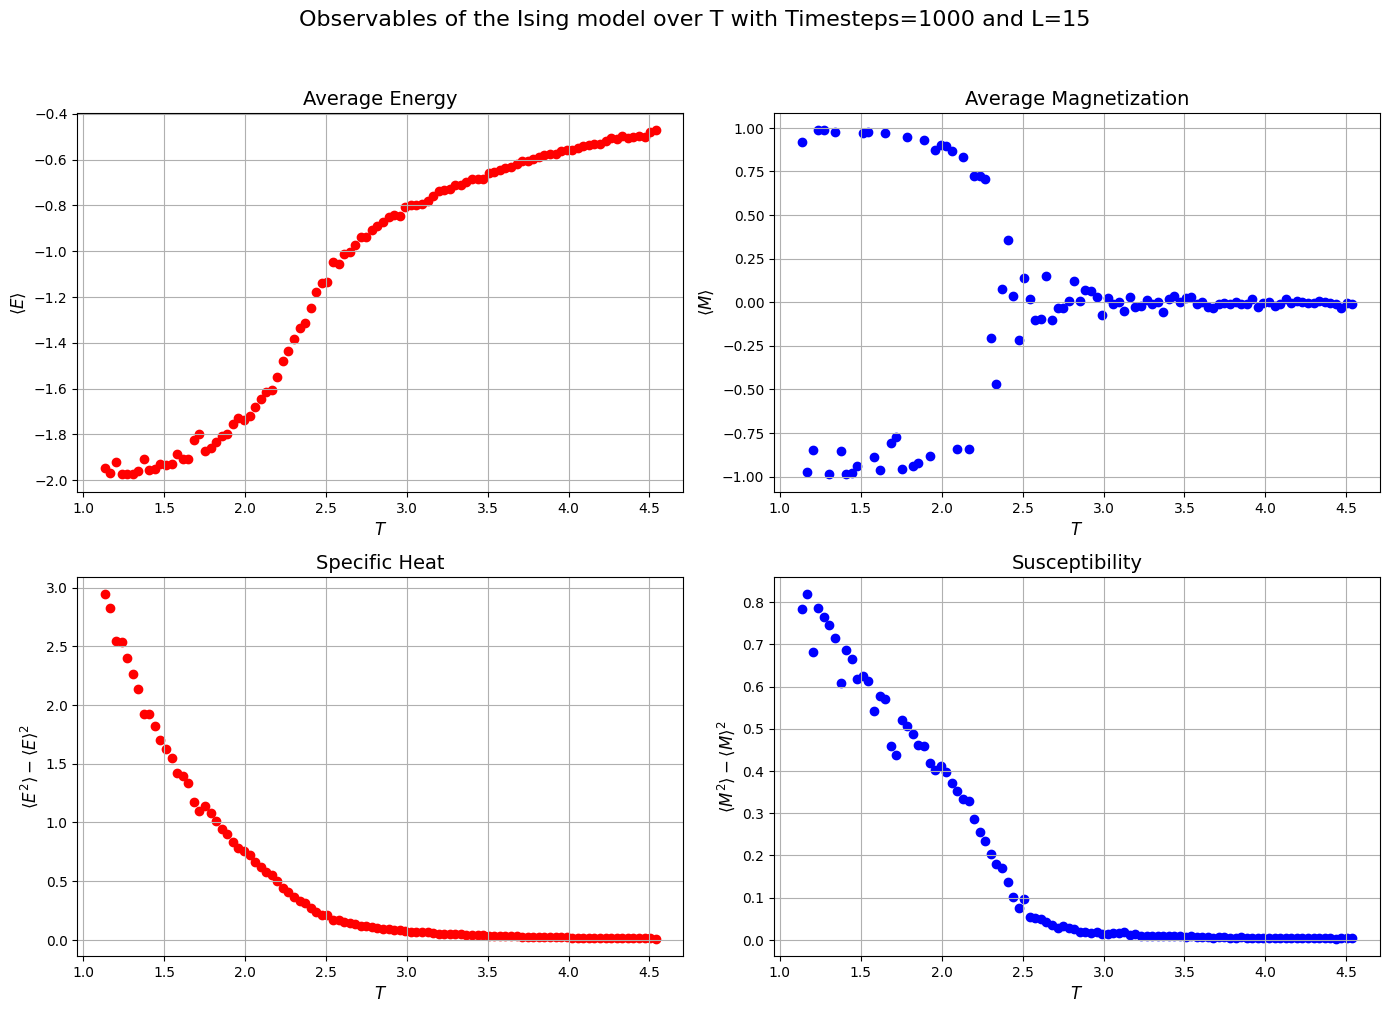

In [38]:
# Create a figure with subplots
plt.figure(figsize=(14, 15))

# Add an overall headline
plt.suptitle("Observables of the Ising model over T with Timesteps=1000 and L=15", fontsize=16, y=0.95)

# Plot 1: Average Energy vs Temperature
plt.subplot(3, 2, 1)
plt.scatter(Ts, E_av, color='red', )
plt.xlabel(r"$T$", fontsize=12)
plt.ylabel(r"$\langle E \rangle$ ", fontsize=12)
plt.title("Average Energy", fontsize=14)
plt.grid(True)


# Plot 2: Average Magnetization vs Temperature
plt.subplot(3, 2, 2)
plt.scatter(Ts, M_av, color='blue', )
plt.xlabel(r"$T$", fontsize=12)
plt.ylabel(r"$\langle M \rangle $", fontsize=12)
plt.title("Average Magnetization", fontsize=14)
plt.grid(True)

# Plot 3: Specific Heat vs Temperature
plt.subplot(3, 2, 3)
plt.scatter(Ts, C_v, color='red', )
plt.xlabel(r"$T$", fontsize=12)
plt.ylabel(r"$ \langle E^2 \rangle - \langle E \rangle^2 $", fontsize=12)
plt.title("Specific Heat", fontsize=14)
plt.grid(True)


# Plot 4: Susceptibility vs Temperature
plt.subplot(3, 2, 4)
plt.scatter(Ts, Chi, color='blue')
plt.xlabel(r"$T$", fontsize=12)
plt.ylabel(r"$ \langle M^2 \rangle - \langle M \rangle^2 $", fontsize=12)
plt.title("Susceptibility", fontsize=14)
plt.grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust layout to fit the suptitle
plt.show()




In [ ]:
import numpy as np
from numba import jit

@jit(nopython=True, cache=True)
def initialize_lattice(N, m0):
    """Initialize lattice with magnetization m0"""
    num_up = int((1 + m0) / 2 * N * N)
    lattice = np.array([-1] * (N * N - num_up) + [1] * num_up)
    np.random.shuffle(lattice)
    return lattice.reshape((N, N))

@jit(nopython=True, cache=True)
def compute_energy(lattice):
    """Compute total energy of the lattice"""
    energy = 0
    N = lattice.shape[0]
    for i in range(N):
        for j in range(N):
            S = lattice[i, j]
            neighbors = (lattice[(i + 1) % N, j] + lattice[i, (j + 1) % N] +
                         lattice[i - 1, j] + lattice[i, j - 1])
            energy += -S * neighbors
    return energy / 2  # Divide by 2 to avoid double counting

@jit(nopython=True, cache=True)
def compute_magnetization(lattice):
    return np.sum(lattice)

@jit(nopython=True, cache=True)
def metropolis_step(lattice, T):
    N = lattice.shape[0]
    # Generate all random numbers at once for efficiency
    random_indices = np.random.randint(0, N, size=(N * N, 2))
    random_probs = np.random.rand(N * N)
    
    for idx in range(N * N):
        i, j = random_indices[idx]
        S = lattice[i, j]
        neighbors = (lattice[(i + 1) % N, j] + lattice[i, (j + 1) % N] +
                     lattice[i - 1, j] + lattice[i, j - 1])
        dE = 2 * S * neighbors  # Energy change if spin is flipped
        
        # Accept flip if energy decreases or with probability exp(-dE/T)
        if dE < 0 or random_probs[idx] < np.exp(-dE / T):
            lattice[i, j] *= -1
    
    return lattice

@jit(nopython=True, cache=True)
def compute_averages(N, m0, Ts, N_steps, N_equilibrium=1000):
    E_av = np.zeros(len(Ts))
    M_av = np.zeros(len(Ts))
    E2_av = np.zeros(len(Ts))
    M2_av = np.zeros(len(Ts))
    C_v = np.zeros(len(Ts))  # Specific heat
    Chi = np.zeros(len(Ts))  # Susceptibility
    
    total_spins = N * N
    
    for idx in range(len(Ts)):
        T = Ts[idx]
        lattice = initialize_lattice(N, m0)
        
        # Equilibration phase - let system reach equilibrium
        for step in range(N_equilibrium):
            lattice = metropolis_step(lattice, T)
        
        # Measurement phase
        energies = np.zeros(N_steps)
        magnetizations = np.zeros(N_steps)
        
        for step in range(N_steps):
            lattice = metropolis_step(lattice, T)
            energies[step] = compute_energy(lattice)
            magnetizations[step] = abs(compute_magnetization(lattice))  # Use absolute value
        
        # Compute averages (per spin)
        E_mean = np.mean(energies) / total_spins
        M_mean = np.mean(magnetizations) / total_spins
        E2_mean = np.mean(energies**2) / (total_spins**2)
        M2_mean = np.mean(magnetizations**2) / (total_spins**2)
        
        E_av[idx] = E_mean
        M_av[idx] = M_mean
        E2_av[idx] = E2_mean
        M2_av[idx] = M2_mean
        
        # Compute specific heat and susceptibility (per spin)
        # C_v = (⟨E²⟩ - ⟨E⟩²) / (k_B T²)
        C_v[idx] = (E2_mean - E_mean**2) * total_spins / (T**2)
        
        # χ = (⟨M²⟩ - ⟨M⟩²) / (k_B T)
        Chi[idx] = (M2_mean - M_mean**2) * total_spins / T
    
    return E_av, M_av, C_v, Chi

# Example usage and plotting
def run_ising_simulation():
    """Example of how to run the simulation and plot results"""
    N = 20  # Lattice size
    m0 = 0.0  # Initial magnetization
    N_steps = 5000  # Number of measurement steps
    N_equilibrium = 2000  # Equilibration steps
    
    # Temperature range around critical temperature (T_c ≈ 2.269 for 2D Ising)
    Ts = np.linspace(1.5, 3.5, 50)
    
    print("Running Ising model simulation...")
    E_av, M_av, C_v, Chi = compute_averages(N, m0, Ts, N_steps, N_equilibrium)
    
    return Ts, E_av, M_av, C_v, Chi



In [44]:
# Parameters
Tc = 2 / np.log(1 + np.sqrt(2))  # Critical temperature
nT = 100  # Number of temperature points
Ts = np.linspace(0.5 * Tc, 2 * Tc, nT)  # Temperature range
N = 15 # Lattice size (N x N)
m0 = 0.0  # Initial magnetization
N_steps = 1000  # Number of Monte Carlo steps

# Compute averages
E_av, M_av, C_v, Chi = compute_averages(N, m0, Ts, N_steps)

# Normalize temperatures by T_c
T_normalized = Ts / Tc

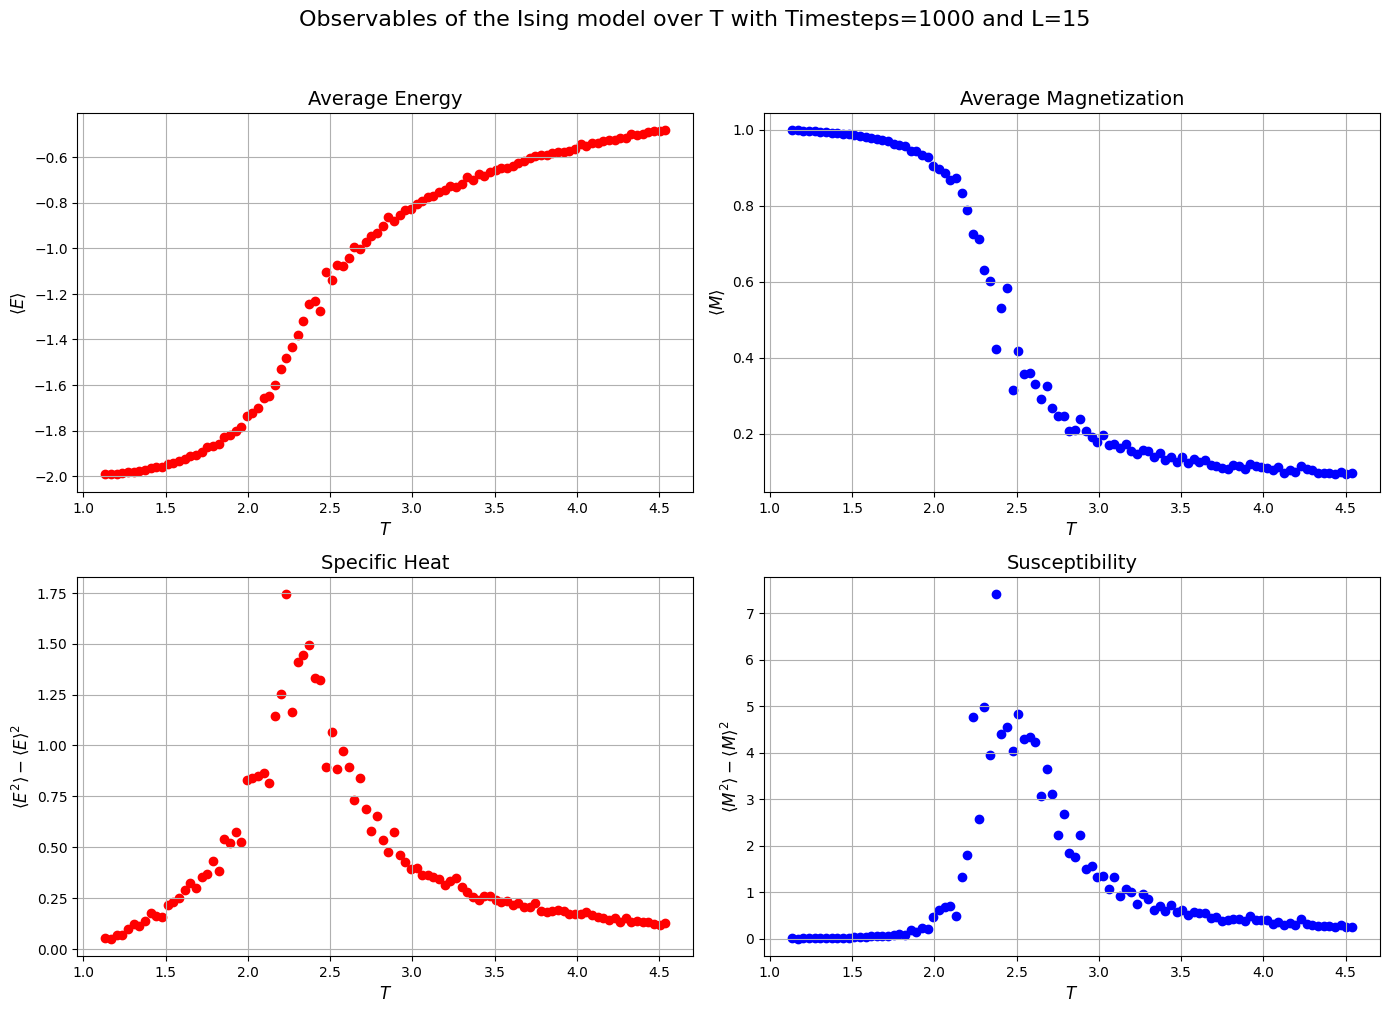

In [45]:

 

# Create a figure with subplots
plt.figure(figsize=(14, 15))

# Add an overall headline
plt.suptitle("Observables of the Ising model over T with Timesteps=1000 and L=15", fontsize=16, y=0.95)

# Plot 1: Average Energy vs Temperature
plt.subplot(3, 2, 1)
plt.scatter(Ts, E_av, color='red', )
plt.xlabel(r"$T$", fontsize=12)
plt.ylabel(r"$\langle E \rangle$ ", fontsize=12)
plt.title("Average Energy", fontsize=14)
plt.grid(True)


# Plot 2: Average Magnetization vs Temperature
plt.subplot(3, 2, 2)
plt.scatter(Ts, M_av, color='blue', )
plt.xlabel(r"$T$", fontsize=12)
plt.ylabel(r"$\langle M \rangle $", fontsize=12)
plt.title("Average Magnetization", fontsize=14)
plt.grid(True)

# Plot 3: Specific Heat vs Temperature
plt.subplot(3, 2, 3)
plt.scatter(Ts, C_v, color='red', )
plt.xlabel(r"$T$", fontsize=12)
plt.ylabel(r"$ \langle E^2 \rangle - \langle E \rangle^2 $", fontsize=12)
plt.title("Specific Heat", fontsize=14)
plt.grid(True)


# Plot 4: Susceptibility vs Temperature
plt.subplot(3, 2, 4)
plt.scatter(Ts, Chi, color='blue')
plt.xlabel(r"$T$", fontsize=12)
plt.ylabel(r"$ \langle M^2 \rangle - \langle M \rangle^2 $", fontsize=12)
plt.title("Susceptibility", fontsize=14)
plt.grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust layout to fit the suptitle
plt.show()


